# Visualize the Data

In [1]:
import vrplib

In [2]:
# source: https://vrp.atd-lab.inf.puc-rio.br/index.php/en/


instance_a = vrplib.read_instance("data/A-n32-k5.vrp")

instance_b = vrplib.read_instance("data/B-n78-k10.vrp")

instance_x = vrplib.read_instance("data/X-n101-k25.vrp")

In [3]:
instance_a.keys()

dict_keys(['name', 'comment', 'type', 'dimension', 'edge_weight_type', 'capacity', 'node_coord', 'demand', 'depot', 'edge_weight'])

In [4]:
import matplotlib.pyplot as plt
import numpy as np



def plot_nodes(instance):
    """
    Visualize a CVRP instance.
    
    param instance: dict returned by vrplib.read_instance
    """
    
    customers = instance["node_coord"]
    depot_idx = instance['depot'][0]
    depot = customers[depot_idx]
    customers = np.delete(customers, depot_idx, axis=0)

    plt.figure()
    plt.scatter(customers[:, 0], customers[:, 1], label = "Customer", color = "r")
    plt.scatter(depot[0], depot[1], label = "Depot", color="b")

    plt.legend()
    plt.grid(True)
    plt.title(f"CVRP Instance {instance["name"]}, Capacity {instance["capacity"]}, No. of customers {len(customers)}")
    

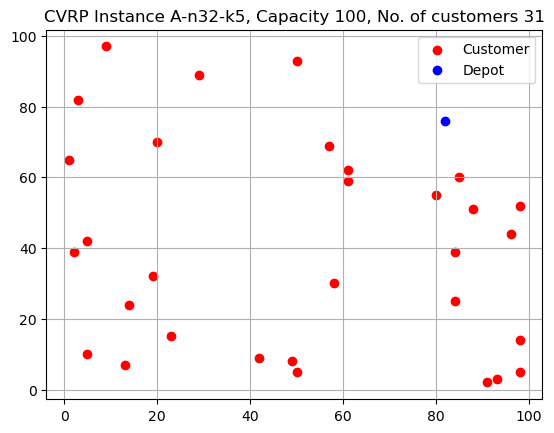

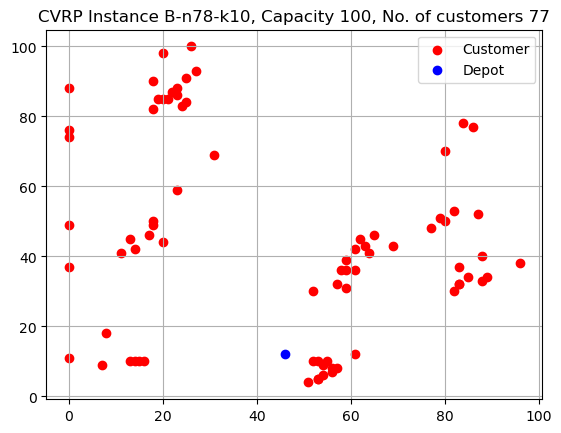

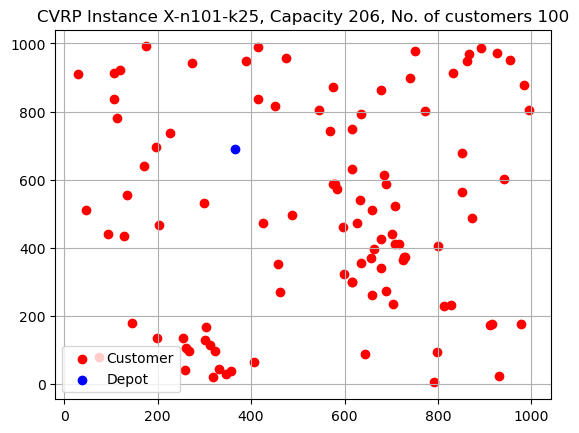

In [5]:

# plot instance a
plot_nodes(instance_a)

# plot instance b
plot_nodes(instance_b)

# plot instance x
plot_nodes(instance_x)

# Implementing algorithm functions and testing them separately

## Creating individual

In [78]:
import random

# Adapted from assignment 1
def create_individual(instance, n_vehicles):
    """
    Create a random solution/individual for the CVRP instance.
    
    An individual consists of:
    - schedule: a permutation of all customer indices (excluding the depot)
    - vehicles_assigned: a list assigning each customer to a vehicle
    
    :param instance: CVRP instance dictionary containing node coordinates and depot info
    :param n_vehicles: number of vehicles available
    
    :return: individual/solution as a list [schedule, vehicles_assigned]
    """

    # Get index of the depot - routes start and end in depot, depot not included in solution
    depot_idx = instance['depot'][0]

    # Excluding depot to get the customer indices (the other locations)
    customer_indices = [i for i in range(len(instance['node_coord'])) if i != depot_idx]

    # Randomly create schedule and assign vehicles
    schedule = random.sample(customer_indices, len(customer_indices))
    vehicles_assigned = np.random.randint(0, n_vehicles, size=len(customer_indices)).tolist()
    
    individual = [schedule, vehicles_assigned]

    return individual
    

In [7]:
import numpy as np

# Test instance created to test the function above
test_instance = {
    "node_coord": np.array([
        [0,0],  
        [4, 4],  
        [2, 2],  
        [3, 4], 
    ]),
    "depot": np.array([0])  # depot index
}
n_vehicles = 2
test_individual = create_individual(test_instance, n_vehicles)


In [8]:
test_individual

[[1, 3, 2], [1, 1, 0]]

## Calculating total distance

In [79]:
# Adapted from Assignment 1
def get_distance(route, instance):
    """
    Calculate the distance of the route of one vehicle, including leaving and returning to depot.

    :param route: List of customer indices in visit order
    :param instance: CVRP instance dictionary with 'depot' and 'edge_weight'
    
    :return: Distance of the route
    """
    
    # Get index of the depot and add it to full route to calculate total distance
    depot_idx = instance['depot'][0]
    full_route = [depot_idx] + route + [depot_idx]
    edge_weight = instance["edge_weight"]

    
    route_distance = 0
    # Add distances from the distance matrix contained by the instance dictionary
    for i in range(len(full_route)-1):
        distance = edge_weight[full_route[i], full_route[i+1]]
        print(f"Distance from {full_route[i]} to {full_route[i+1]}: {distance}")
        route_distance += distance 
        
    return route_distance


def total_distance(individual, instance, n_vehicles):
    """
    Compute the total distance for all routes of an individual/solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles
    
    :return: Sum of distances of all routes
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)
        
    total_distance = 0 
    print(f"Routes: {routes}")

    # Sum the distances for each vehicle route
    for route in routes:
        print("\n\n\n ")
        print(f"Route {route} ")
        route_distance = get_distance(route, instance)
        print(f"Route {route} distance: {route_distance}")
        total_distance += route_distance
        
    return total_distance
    
    


In [80]:

# Test data created for testing the function above
# Adding Euclidean distance matrix to test instance

from scipy.spatial.distance import cdist
node_coords = test_instance["node_coord"]
edge_weight = cdist(node_coords, node_coords, metric='euclidean')
test_instance["edge_weight"] = edge_weight


In [11]:
edge_weight

array([[0.        , 5.65685425, 2.82842712, 5.        ],
       [5.65685425, 0.        , 2.82842712, 1.        ],
       [2.82842712, 2.82842712, 0.        , 2.23606798],
       [5.        , 1.        , 2.23606798, 0.        ]])

In [12]:
total_distance(test_individual, test_instance, n_vehicles)

Routes: [[2], [1, 3]]



 
Route [2] 
Distance from 0 to 2: 2.8284271247461903
Distance from 2 to 0: 2.8284271247461903
Route [2] distance: 5.656854249492381



 
Route [1, 3] 
Distance from 0 to 1: 5.656854249492381
Distance from 1 to 3: 1.0
Distance from 3 to 0: 5.0
Route [1, 3] distance: 11.65685424949238


17.31370849898476

## Calculating route balance

In [81]:
def route_balance_std(individual, instance, n_vehicles):
    """
    Compute the route balance metric - Standard Deviation of Route Lengths
    for a given individual/ solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles

    :return: Standard Deviation of Route Lengths
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)

    # Append distances for each vehicle route and compute standard deviation
    route_lengths = []

    for route in routes:
        print("\n\n\n ")
        print(f"Route {route} ")
        route_distance = get_distance(route, instance)
        print(f"Route {route} distance: {route_distance}")
        route_lengths.append(route_distance)


    route_balance_std = np.std(route_lengths)
    return route_balance_std
    
    

In [14]:
route_balance_std(test_individual, test_instance, n_vehicles)




 
Route [2] 
Distance from 0 to 2: 2.8284271247461903
Distance from 2 to 0: 2.8284271247461903
Route [2] distance: 5.656854249492381



 
Route [1, 3] 
Distance from 0 to 1: 5.656854249492381
Distance from 1 to 3: 1.0
Distance from 3 to 0: 5.0
Route [1, 3] distance: 11.65685424949238


2.9999999999999996

## Feasibility of solution

In [82]:
import copy
import random


# inspired by https://transport-systems.imperial.ac.uk/tf/60008_21/n6_10_vehicle_routing_problem-genetic_algorithm.html


def vehicle_capacity_repair(individual, instance, n_vehicles, max_iters=1000):
    """
    Repairs an individual (schedule + vehicle assignments) to respect vehicle capacity, 
    by moving customers to different vehicles.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles
    :param max_iters: maximum iterations to try repairing

    :return: repaired individual with no vehicle exceeding capacity if possible

    

    Parameters:
    - individual: [schedule, vehicles], the VRP solution
    - instance: CVRP instance containing capacity and demand
    - n_vehicles: number of vehicles
    - max_iters: maximum iterations to try repairing

    Returns:
    - repaired individual: [schedule, vehicles] with no vehicle exceeding capacity (if possible)
    """
    
    schedule, vehicles = copy.deepcopy(individual)

    
    capacity = instance["capacity"]
    demand = instance["demand"][1:]

    vehicle_loads = [0]*n_vehicles
    for cust_id, vehicle in zip(schedule, vehicles):
        vehicle_loads[vehicle] += demand[cust_id-1]

    print("Initial Loads:", vehicle_loads)
    excess_load = [capacity - load for load in vehicle_loads]

    iters = 0
    
    while any(e < 0 for e in excess_load) and iters < max_iters:
        iters += 1
        v_id = next(i for i, e in enumerate(excess_load) if e < 0)
        idx_customers = [i for i, v in enumerate(vehicles) if v == v_id]
        moved = False

        for idx_to_move in random.sample(idx_customers, len(idx_customers)):
            cust_id = schedule[idx_to_move]
            demand_to_move = demand[cust_id-1]

            fit_vehicles = [i for i, e in enumerate(excess_load) if e >= demand_to_move and i != v_id]
            if not fit_vehicles:
                continue

            to_vehicle = random.choice(fit_vehicles)
            vehicles[idx_to_move] = to_vehicle
            excess_load[v_id] += demand_to_move
            excess_load[to_vehicle] -= demand_to_move
            moved = True
            print(f"Moved customer {cust_id} from vehicle {v_id} to {to_vehicle}")
            break

        if not moved:
            print("Cannot repair further: no customer can fit any vehicle")
            break

    # Final loads
    vehicle_loads = [0]*n_vehicles
    for cust_id, vehicle in zip(schedule, vehicles):
        vehicle_loads[vehicle] += demand[cust_id-1]

    print("Final Loads after repair:", vehicle_loads)
    return [schedule, vehicles]



    
# Test data for the function above
test_instance["demand"] = np.array([0, 3, 3, 1])
test_instance["capacity"] = 5
test_individual = [[3, 1, 2], [0, 1, 1]]

print("Test individual:")
print(test_individual)


ind_copy = copy.deepcopy(test_individual)
repaired_individual = vehicle_capacity_repair(ind_copy, test_instance, n_vehicles)


print("Repaired individual")
print(repaired_individual)


schedule, vehicles = repaired_individual
vehicle_loads = [0] * n_vehicles
demand = test_instance["demand"][1:]
capacity = test_instance["capacity"]
for customer, vehicle in zip(schedule, vehicles):
    vehicle_loads[vehicle] += demand[customer-1]

print("Repaired Loads:")
print(vehicle_loads)
    
    

Test individual:
[[3, 1, 2], [0, 1, 1]]
Initial Loads: [1, 6]
Moved customer 2 from vehicle 1 to 0
Final Loads after repair: [4, 3]
Repaired individual
[[3, 1, 2], [0, 1, 0]]
Repaired Loads:
[4, 3]


# Implementing non dominated sorting

In [83]:
# Inspired by lab 4
class Solution:
    """
    Represents a solution (individual) in the population.
    """
    
    def __init__(self, x):
        self.x = x
        self.objectives = None
        self.rank = None
        self.crowding_distance = None


In [84]:
import random

# Adapted from assignment 1

def create_individual(instance, n_vehicles):
    """
    Create a random solution/individual for the CVRP instance.
    
    An individual consists of:
    - schedule: a permutation of all customer indices (excluding the depot)
    - vehicles_assigned: a list assigning each customer to a vehicle
    
    :param instance: CVRP instance dictionary containing node coordinates and depot info
    :param n_vehicles: number of vehicles available
    
    :return: individual/solution as a list [schedule, vehicles_assigned]
    """
    
    # Get index of the depot - routes start and end in depot, depot not included in solution
    depot_idx = instance['depot'][0]

    # Excluding depot to get the customer indices (the other locations)
    customer_indices = [i for i in range(len(instance['node_coord'])) if i != depot_idx]

    # Randomly create schedule and assign vehicles
    schedule = random.sample(customer_indices, len(customer_indices))
    vehicles_assigned = np.random.randint(0, n_vehicles, size=len(customer_indices)).tolist()
    
    individual = [schedule, vehicles_assigned]

    return individual

In [26]:
# Test instance created to test non dominated sorting


test_instance = {
    "node_coord": np.array([
        [0,0],  
        [4, 12],  
        [12, 2],  
        [0, 4], 
    ]),
    "depot": np.array([0])  # depot index
}
n_vehicles = 2

sol_1 = Solution(create_individual(test_instance, n_vehicles))
sol_2 = Solution(create_individual(test_instance, n_vehicles))

print(f"Sol 1: {sol_1.x}")
print(f"Sol 2: {sol_2.x}")


Sol 1: [[3, 1, 2], [0, 0, 0]]
Sol 2: [[2, 1, 3], [1, 0, 1]]


In [27]:
# Adapted from assignment 1

def get_distance(route, instance):
    """
    Calculate the distance of the route of one vehicle, including leaving and returning to depot.

    :param route: List of customer indices in visit order
    :param instance: CVRP instance dictionary with 'depot' and 'edge_weight'
    
    :return: Distance of the route
    """
    
    # Get index of the depot and add it to full route to calculate total distance
    depot_idx = instance['depot'][0]
    full_route = [depot_idx] + route + [depot_idx]
    edge_weight = instance["edge_weight"]

    
    route_distance = 0
    # Add distances from the distance matrix contained by the instance dictionary
    for i in range(len(full_route)-1):
        route_distance += edge_weight[full_route[i], full_route[i+1]]
        
    return route_distance



def total_distance(individual, instance, n_vehicles):
    """
    Compute the total distance for all routes of an individual/solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles
    
    :return: Sum of distances of all routes
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)
        
    total_distance = 0 
    print(f"Routes: {routes}")

    # Sum the distances for each vehicle route
    for route in routes:
        total_distance += get_distance(route, instance)
        
    return total_distance
    
def route_balance_std(individual, instance, n_vehicles):
    """
    Compute the route balance metric - Standard Deviation of Route Lengths
    for a given individual/ solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles

    :return: Standard Deviation of Route Lengths
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)

    # Append distances for each vehicle route and compute standard deviation
    route_lengths = []

    for route in routes:
        route_lengths.append(get_distance(route, instance))


    route_balance_std = np.std(route_lengths)
    return route_balance_std
    
    


# Test instance created to test non dominated sorting
from scipy.spatial.distance import cdist
node_coords = test_instance["node_coord"]
edge_weight = cdist(node_coords, node_coords, metric='euclidean')
test_instance["edge_weight"] = edge_weight

# Computing objectives values for on dominated sorting
objective_functions = [total_distance, route_balance_std]
sol_1.objectives = [f(sol_1.x, test_instance, n_vehicles) for f in objective_functions]
sol_2.objectives = [f(sol_2.x, test_instance, n_vehicles) for f in objective_functions]


print(f"Sol 1 objectives: {sol_1.objectives}")
print(f"Sol 2 objectives: {sol_2.objectives}")


Sol 1 objectives: [37.91604544546129, 18.958022722730647]
Sol 2 objectives: [53.62927140253991, 1.5164144199229206]


In [28]:
# Inspired by lab 4
def dominates(sol1, sol2):
    """
    Check if solution sol1 dominates solution sol2.
    sol1 dominates sol2 if:
    1. It is not worse than sol2 in all objectives
    2. It is better than sol2 in one objective
    Better means a lower value (minimization).
    
    :param sol1: First solution/ individual
    :param sol2: Second solution/ individual
    
    :return: True if sol1 dominates sol2, False otherwise
    """
    
    obj1 = sol1.objectives
    obj2 = sol2.objectives

    # Check it is not worse than sol2 in all objectives
    all_less_equal = all(a <= b for a, b in zip(obj1, obj2))
    
    # Check it is better than sol2 in at least one objective
    any_strictly_less = any(a < b for a, b in zip(obj1, obj2))
    
    return all_less_equal and any_strictly_less

dominates(sol_1, sol_2)

False

In [85]:
# Inspired by lab 4
def non_dominated_sort(population):
    """
    Perform non-dominated sorting on the population.

    :param population: list of Solution objects
    
    This function assigns a rank to each solution based on non-domination.
    Rank 1 solutions are non-dominated (not dominated by any other solutions), 
    rank 2 are dominated only by rank 1, and so on.
    """
    for p in population:
        p.domination_count = 0
        p.dominated_solutions = []
        for q in population:
            if dominates(p, q):
                p.dominated_solutions.append(q)
            elif dominates(q, p):
                p.domination_count += 1
        if p.domination_count == 0:
            p.rank = 1

    front = 1
    while True:
        current_front = [p for p in population if p.rank == front]
        if not current_front:
            break
        for p in current_front:
            for q in p.dominated_solutions:
                q.domination_count -= 1
                if q.domination_count == 0:
                    q.rank = front + 1
        front += 1

In [30]:
# Test instance created to test non dominated sorting
test_instance = {
    "node_coord": np.array([
        [0,0],  
        [4, 12],  
        [12, 2],  
        [0, 4], 
        [3,9], 
    ]),
    "depot": np.array([0])  # depot index
}
n_vehicles = 2
from scipy.spatial.distance import cdist
node_coords = test_instance["node_coord"]
edge_weight = cdist(node_coords, node_coords, metric='euclidean')
test_instance["edge_weight"] = edge_weight



population = [Solution(create_individual(test_instance, n_vehicles)) for i in range(7)]
for p in population:
    p.objectives = [f(p.x, test_instance, n_vehicles) for f in objective_functions]
print("Before sorting:")
for i, p in enumerate(population):
    print(f"Individual {i}: {p.x}, Objectives: {p.objectives}")
    
non_dominated_sort(population)
print("\nAfter non-dominated sorting:")
for i, p in enumerate(population):
    print(f"Individual {i}: {p.x}, Objectives: {p.objectives}, Rank: {p.rank}")

Before sorting:
Individual 0: [[2, 4, 1, 3], [0, 0, 1, 0]], Objectives: [58.69645248778015, 4.05000496254304]
Individual 1: [[1, 2, 3, 4], [0, 1, 1, 1]], Objectives: [64.94705627789035, 7.175306857598139]
Individual 2: [[2, 1, 4, 3], [0, 0, 1, 0]], Objectives: [56.88971140647157, 9.471189742225508]
Individual 3: [[4, 2, 3, 1], [1, 0, 0, 0]], Objectives: [64.89809863287583, 13.475383355427638]
Individual 4: [[4, 2, 1, 3], [0, 0, 1, 1]], Objectives: [58.64749484276563, 3.7303648707101367]
Individual 5: [[3, 4, 2, 1], [1, 1, 1, 0]], Objectives: [58.69645248778015, 4.05000496254304]
Individual 6: [[4, 3, 1, 2], [0, 1, 0, 1]], Objectives: [53.62927140253991, 1.5164144199229188]

After non-dominated sorting:
Individual 0: [[2, 4, 1, 3], [0, 0, 1, 0]], Objectives: [58.69645248778015, 4.05000496254304], Rank: 3
Individual 1: [[1, 2, 3, 4], [0, 1, 1, 1]], Objectives: [64.94705627789035, 7.175306857598139], Rank: 4
Individual 2: [[2, 1, 4, 3], [0, 0, 1, 0]], Objectives: [56.88971140647157, 9.471

Before sorting:
Individual 0: [[5, 1, 2, 6, 3, 4], [1, 0, 0, 1, 0, 0]], Objectives: [86.34663084431725, 9.765353629327468]
Individual 1: [[5, 6, 4, 3, 1, 2], [1, 0, 1, 0, 1, 1]], Objectives: [68.16129011610532, 17.289678595255072]
Individual 2: [[6, 4, 2, 1, 3, 5], [0, 1, 0, 1, 0, 1]], Objectives: [62.60066011367971, 2.9692799356469752]
Individual 3: [[5, 6, 3, 4, 1, 2], [1, 1, 0, 0, 1, 0]], Objectives: [84.55288099713852, 8.878209292136141]
Individual 4: [[5, 3, 2, 4, 1, 6], [1, 0, 1, 1, 0, 1]], Objectives: [77.44044145627868, 13.126838177466663]
Individual 5: [[6, 1, 5, 4, 2, 3], [0, 1, 0, 1, 0, 1]], Objectives: [65.79336672448704, 7.254343166556328]
Individual 6: [[1, 5, 6, 3, 4, 2], [0, 0, 1, 0, 0, 1]], Objectives: [71.10419411208252, 11.221046934848387]
Individual 7: [[1, 4, 6, 3, 5, 2], [0, 1, 1, 1, 0, 0]], Objectives: [69.75171538677756, 6.136817035066747]
Individual 8: [[1, 3, 6, 5, 4, 2], [0, 1, 0, 0, 1, 0]], Objectives: [77.21549940202453, 19.289964825661826]

After non-domin

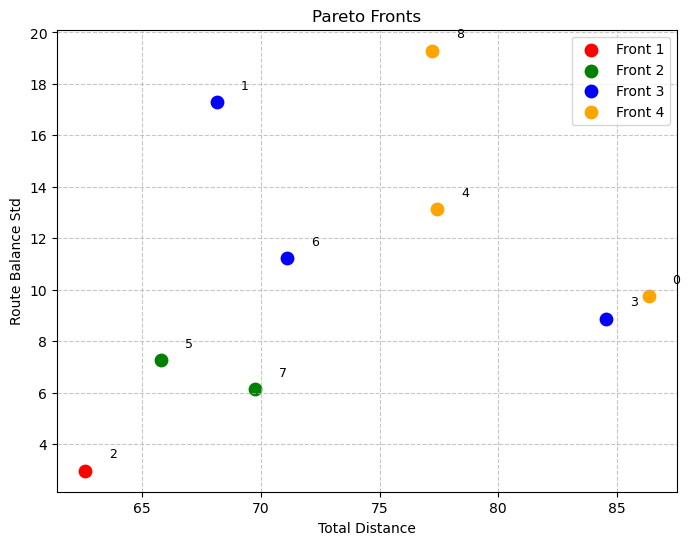

In [33]:
# Test instance created to test non dominated sorting

test_instance = {
    "node_coord": np.array([
        [0,0],  
        [4, 12],  
        [12, 2],  
        [0, 4], 
        [3,9], 
        [10, 12], 
        [6,1],
    ]),
    "depot": np.array([0])  # depot index
}
n_vehicles = 2
from scipy.spatial.distance import cdist
node_coords = test_instance["node_coord"]
edge_weight = cdist(node_coords, node_coords, metric='euclidean')
test_instance["edge_weight"] = edge_weight




import matplotlib.pyplot as plt
population = [Solution(create_individual(test_instance, n_vehicles)) for i in range(9)]
for p in population:
    p.objectives = [f(p.x, test_instance, n_vehicles) for f in objective_functions]
print("Before sorting:")
for i, p in enumerate(population):
    print(f"Individual {i}: {p.x}, Objectives: {p.objectives}")
    
non_dominated_sort(population)
print("\nAfter non-dominated sorting:")
for i, p in enumerate(population):
    print(f"Individual {i}: {p.x}, Objectives: {p.objectives}, Rank: {p.rank}")
# Get unique ranks
ranks = sorted(set(p.rank for p in population))
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

plt.figure(figsize=(8,6))

for i, rank in enumerate(ranks):
    front = [p for p in population if p.rank == rank]
    x = [p.objectives[0] for p in front]  # total distance
    y = [p.objectives[1] for p in front]  # route balance std
    plt.scatter(x, y, color=colors[i % len(colors)], label=f'Front {rank}', s=80)
        # Annotate points with their indices
    for j, p_ind in enumerate(front):
        plt.text(x[j]+1, y[j]+0.5, str(population.index(p_ind)), fontsize=9, color='black')


plt.xlabel('Total Distance')
plt.ylabel('Route Balance Std')
plt.title('Pareto Fronts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Implementing crowding distance

In [34]:
# From lab 4

def calculate_crowding_distance(population):
    """
    Calculate crowding distance for each solution in the population.
    
    Crowding distance is a measure of how close a solution is to its neighbors.
    It's used to maintain diversity in the population. 
    
    For each front, extreme solutions are assigned infinity.
    """
    for front in set(s.rank for s in population):
        front_solutions = [s for s in population if s.rank == front]
        if len(front_solutions) <= 2:
            for s in front_solutions:
                s.crowding_distance = float('inf')
            continue
        
        num_objectives = len(front_solutions[0].objectives)
        for i in range(num_objectives):
            front_solutions.sort(key=lambda x: x.objectives[i])
            front_solutions[0].crowding_distance = front_solutions[-1].crowding_distance = float('inf')
            
            for j in range(1, len(front_solutions) - 1):
                if front_solutions[-1].objectives[i] == front_solutions[0].objectives[i]:
                    front_solutions[j].crowding_distance = 0
                else:
                    front_solutions[j].crowding_distance = (front_solutions[j+1].objectives[i] - front_solutions[j-1].objectives[i]) / \
                                                           (front_solutions[-1].objectives[i] - front_solutions[0].objectives[i])
        
        for s in front_solutions:
            if s.crowding_distance is None:
                s.crowding_distance = 0
            else:
                s.crowding_distance += s.crowding_distance
calculate_crowding_distance(population)
i = 0
for p in population:
    print(f"{p.x} - Crowding distance {p.crowding_distance} - Rank {p.rank}")
    i += 1

[[5, 1, 2, 6, 3, 4], [1, 0, 0, 1, 0, 0]] - Crowding distance inf - Rank 4
[[5, 6, 4, 3, 1, 2], [1, 0, 1, 0, 1, 1]] - Crowding distance inf - Rank 3
[[6, 4, 2, 1, 3, 5], [0, 1, 0, 1, 0, 1]] - Crowding distance inf - Rank 1
[[5, 6, 3, 4, 1, 2], [1, 1, 0, 0, 1, 0]] - Crowding distance inf - Rank 3
[[5, 3, 2, 4, 1, 6], [1, 0, 1, 1, 0, 1]] - Crowding distance 2.0 - Rank 4
[[6, 1, 5, 4, 2, 3], [0, 1, 0, 1, 0, 1]] - Crowding distance inf - Rank 2
[[1, 5, 6, 3, 4, 2], [0, 0, 1, 0, 0, 1]] - Crowding distance 2.0 - Rank 3
[[1, 4, 6, 3, 5, 2], [0, 1, 1, 1, 0, 0]] - Crowding distance inf - Rank 2
[[1, 3, 6, 5, 4, 2], [0, 1, 0, 0, 1, 0]] - Crowding distance inf - Rank 4


# Implementing Parent Selection

In [42]:
# Adapted from Lab 4

def tournament_selection(population):
    """
    Perform tournament selection to choose a parent.
    
    :param population: list of Solution objects
    
    :return: Selected solution
    """
    tournament = np.random.choice(population, 2, replace=False)

    for t in tournament:
        print(f"Candidate {t.x}, rank{t.rank}, crowding distance {t.crowding_distance}")
        
    return min(tournament, key=lambda x: (x.rank, -(x.crowding_distance or 0)))


print("Test 1:")
parent = tournament_selection(population)
print("Parent Selected:")
print(parent.x)


print("\n\n\nTest 2:")

parent = tournament_selection(population)
print("Parent Selected:")
print(parent.x)


Test 1:
Candidate [[1, 3, 6, 5, 4, 2], [0, 1, 0, 0, 1, 0]], rank4, crowding distance inf
Candidate [[5, 3, 2, 4, 1, 6], [1, 0, 1, 1, 0, 1]], rank4, crowding distance 2.0
Parent Selected:
[[1, 3, 6, 5, 4, 2], [0, 1, 0, 0, 1, 0]]



Test 2:
Candidate [[6, 1, 5, 4, 2, 3], [0, 1, 0, 1, 0, 1]], rank2, crowding distance inf
Candidate [[6, 4, 2, 1, 3, 5], [0, 1, 0, 1, 0, 1]], rank1, crowding distance inf
Parent Selected:
[[6, 4, 2, 1, 3, 5], [0, 1, 0, 1, 0, 1]]


# Implementing crossover

In [43]:
# CROSSOVER

# Solution/ individual: [[schedule, vehicles assigned]]
# Schedule -> Permutation of customer idx
# Vehicles assigned -> Integers

# individual: [[route][vehicles]]
# [route] -> Permutation
# [vehicles] -> INTEGERS

# parents crossover: crossover for routes + crossover for vehicles

from random import randint, uniform, shuffle


def pmx(parent1, parent2, start, end):
    """
    Partially Mapped Crossover (PMX) for permutations.

    :param parent1: parent permutation (customer indices)
    :param parent2: parent permutation (customer indices)

    :return: one child resulting from PMX
    
    """
    
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]

    for ind, x in enumerate(parent2[start:end]):
        ind += start
        if x not in child:
            while child[ind] != None:
                ind = parent2.index(parent1[ind])
            child[ind] = x

    for ind, x in enumerate(child):
        if x == None:
            child[ind] = parent2[ind]

    return child



# Uniform crossover for vehicles
# each gene is treated independently
# for each gene, choosing randomly from which parent to take the genes from
def uniform_crossover(vehicles1, vehicles2):
    """
    Uniform crossover for vehicle assignments.
    Each gene is treated independently.
    For each gene, choosing randomly from which parent to take the genes from.

    :param vehicles1: vehicle assignment list
    :param vehicles2: vehicle assignment list

    :returns: two children vehicle assignments
    """

    
    child1 = []
    child2 = []

    # For each gene, choosing randomly from which parents to inherit 
    for v1, v2 in zip(vehicles1, vehicles2):
        
        if random.random() < 0.5:
            child1.append(v1)
            child2.append(v2)
            
        else:
            child2.append(v1)
            child1.append(v2)   
            
    return child1, child2
        



def crossover_(parent1, parent2):
    """
    Performing crossover on two individuals/solutions.

    :param parent1: a Solution object
    :param parent2: a Solution object

    :returns: two children Solution objects
    """

    
    # Extract schedule and vehicles from Solution objects
    p1_schedule, p1_vehicles = parent1.x
    p2_schedule, p2_vehicles = parent2.x

    
    # Apply PMX for schedules (permutations)
    half = len(parent1)//2
    start = randint(0, len(parent1)-half)
    end = start + half
    child_route1 = pmx(p1_schedule, p2_schedule, start, end)
    child_route2 = pmx(p2_schedule, p1_schedule, start, end)

    # Apply uniform crossover for vehicles assignments (lists of integers)
    child_vehicles1, child_vehicles2 = uniform_crossover(p1_vehicles, p2_vehicles)

    # Create children Solution objects 
    child1 = Solution([child_route1, child_vehicles1])
    child2 = Solution([child_route2, child_vehicles2])

    return child1, child2

    


In [45]:

# Test data to test crossover
import numpy as np
test_instance = {
    "node_coord": np.array([
        [0,0],  
        [4, 12],  
        [12, 2],  
        [0, 4], 
        [2, 12],
    ]),
    "depot": np.array([0])  # depot index
}
n_vehicles = 2

sol_1 = Solution(create_individual(test_instance, n_vehicles))
sol_2 = Solution(create_individual(test_instance, n_vehicles))

print(f"Sol 1: {sol_1.x}")
print(f"Sol 2: {sol_2.x}")


child1, child2 = crossover_(sol_1, sol_2)

print(f"Child1: {child1.x}")
print(f"Child2: {child2.x}")


Sol 1: [[2, 3, 4, 1], [1, 1, 0, 1]]
Sol 2: [[3, 1, 4, 2], [1, 1, 0, 0]]
Child1: [[1, 3, 4, 2], [1, 1, 0, 0]]
Child2: [[2, 1, 4, 3], [1, 1, 0, 1]]


# Implementing Mutation

In [69]:
# MUTATION
# Solution/ individual: [[schedule, vehicles assigned]]
# Schedule -> Permutation of customer idx
# Vehicles assigned -> Integers
# MUTATION CAN BE route mutation or vehicles mutation

def mutate_routes(route):
    """
    Randomly mutates a route by scrambling a segment of the route.

    :param route: list of customer idx

    :return: mutated route
    """
    if len(route) < 2:
        return route

    # Select and scramble segment
    start, end = sorted(random.sample(range(len(route)), 2))
    segment = route[start:end+1]
    random.shuffle(segment)
    
    # Create new route
    new_route = route[:start] + segment + route[end+1:]
    
    return new_route


# function for vehicles mutation
# random resetting
# in each position, with a probability
# replace with a new vehicle value 
# from the list of admissible values

def mutate_vehicles(vehicles, mutation_prob, n_vehicles):
    """
    Mutates assigned vehicles with random resetting.
    In each position, with a probability, replace 
    with a new vehicle value, 
    from the list of admissible values.

    :param vehicles: list of assigned vehicles (integers)
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles


    return: mutated vehicles assignment
    """
    
    mutated = vehicles.copy()
    
    for i in range(len(mutated)):
        if random.random() < mutation_prob:
            old_v = vehicles[i]
            mutated[i] = random.choice([v for v in range(n_vehicles) if v != old_v])
            
    return mutated

def pick_mutation(individual, mutation_prob, n_vehicles):
    """
    Decide which part of individual (schedule or 
    assigned vehicles) to mutate.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles

    :return mutated individual
    
    """
    
    route, vehicles = individual[0], individual[1]
    
    if random.random() < 0.5:
        route = mutate_routes(route)
    
    else:
        vehicles = mutate_vehicles(vehicles, mutation_prob, n_vehicles)
        
    return [route, vehicles]


def mutate(individual, mutation_prob, n_vehicles):
    """
    Decides if individual is mutated.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles
    
    :return mutated individual or original individual
    """
    
    if random.random() < mutation_prob:
        mutated = pick_mutation(individual, mutation_prob, n_vehicles)
        return mutated
        
    return individual
        
        


In [70]:
# Test data for mutation
sol = Solution(create_individual(test_instance, n_vehicles))

print(f"Sol : {sol.x}")

sol.x = mutate(sol.x, 0.9, 2)

print(f"Mutated sol 1: {sol.x}")

Sol : [[2, 4, 1, 3], [1, 1, 1, 0]]
Mutated sol 1: [[2, 3, 1, 4], [1, 1, 1, 0]]


# Main Algorithm

In [89]:
class Solution:
    """
    Represents a solution (individual) in the population.
    """
    def __init__(self, x):
        self.x = x
        self.objectives = None
        self.rank = None
        self.crowding_distance = None

In [90]:
import numpy as np
import random

# Adapted from assignment 1
def create_individual(instance, n_vehicles):
    """
    Create a random solution/individual for the CVRP instance.
    
    An individual consists of:
    - schedule: a permutation of all customer indices (excluding the depot)
    - vehicles_assigned: a list assigning each customer to a vehicle
    
    :param instance: CVRP instance dictionary containing node coordinates and depot info
    :param n_vehicles: number of vehicles available
    
    :return: individual/solution as a list [schedule, vehicles_assigned]
    """
    # Get index of the depot - routes start and end in depot, depot not included in solution
    depot_idx = instance['depot'][0]

    # Excluding depot to get the customer indices (the other locations)
    customer_indices = [i for i in range(len(instance['node_coord'])) if i != depot_idx]

    # Randomly create schedule and assign vehicles
    schedule = random.sample(customer_indices, len(customer_indices))
    vehicles_assigned = np.random.randint(0, n_vehicles, size=len(customer_indices)).tolist()
    individual = [schedule, vehicles_assigned]

    return individual    

In [97]:
# Adapted from assignment 1

def get_distance(route, instance):
    """
    Calculate the distance of the route of one vehicle, including leaving and returning to depot.

    :param route: List of customer indices in visit order
    :param instance: CVRP instance dictionary with 'depot' and 'edge_weight'
    
    :return: Distance of the route
    """
    
    # Get index of the depot and add it to full route to calculate total distance
    depot_idx = instance['depot'][0]
    full_route = [depot_idx] + route + [depot_idx]
    edge_weight = instance["edge_weight"]

    
    route_distance = 0
    # Add distances from the distance matrix contained by the instance dictionary
    for i in range(len(full_route)-1):
        route_distance += edge_weight[full_route[i], full_route[i+1]]
        
    return route_distance



def total_distance(individual, instance, n_vehicles):
    """
    Compute the total distance for all routes of an individual/solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles
    
    :return: Sum of distances of all routes
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)
        
    total_distance = 0 

    # Sum the distances for each vehicle route
    for route in routes:
        total_distance += get_distance(route, instance)
        
    return total_distance
    
def route_balance_std(individual, instance, n_vehicles):
    """
    Compute the route balance metric - Standard Deviation of Route Lengths
    for a given individual/ solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles

    :return: Standard Deviation of Route Lengths
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)

    # Append distances for each vehicle route and compute standard deviation
    route_lengths = []

    for route in routes:
        route_lengths.append(get_distance(route, instance))


    route_balance_std = np.std(route_lengths)
    return route_balance_std

In [109]:
# CROSSOVER

# Solution/ individual: [[schedule, vehicles assigned]]
# Schedule -> Permutation of customer idx
# Vehicles assigned -> Integers

# individual: [[route][vehicles]]
# [route] -> Permutation
# [vehicles] -> INTEGERS

# parents crossover: crossover for routes + crossover for vehicles

from random import randint, uniform, shuffle


def pmx(parent1, parent2, start, end):
    """
    Partially Mapped Crossover (PMX) for permutations.

    :param parent1: parent permutation (customer indices)
    :param parent2: parent permutation (customer indices)

    :return: one child resulting from PMX
    
    """
    
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]

    for ind, x in enumerate(parent2[start:end]):
        ind += start
        if x not in child:
            while child[ind] != None:
                ind = parent2.index(parent1[ind])
            child[ind] = x

    for ind, x in enumerate(child):
        if x == None:
            child[ind] = parent2[ind]

    return child



# Uniform crossover for vehicles
# each gene is treated independently
# for each gene, choosing randomly from which parent to take the genes from
def uniform_crossover(vehicles1, vehicles2):
    """
    Uniform crossover for vehicle assignments.
    Each gene is treated independently.
    For each gene, choosing randomly from which parent to take the genes from.

    :param vehicles1: vehicle assignment list
    :param vehicles2: vehicle assignment list

    :returns: two children vehicle assignments
    """

    
    child1 = []
    child2 = []

    # For each gene, choosing randomly from which parents to inherit 
    for v1, v2 in zip(vehicles1, vehicles2):
        
        if random.random() < 0.5:
            child1.append(v1)
            child2.append(v2)
            
        else:
            child2.append(v1)
            child1.append(v2)   
            
    return child1, child2
        



def crossover_(parent1, parent2):
    """
    Performing crossover on two individuals/solutions.

    :param parent1: a Solution object
    :param parent2: a Solution object

    :returns: two children Solution objects
    """

    
    # Extract schedule and vehicles from Solution objects
    p1_schedule, p1_vehicles = parent1.x
    p2_schedule, p2_vehicles = parent2.x

    
    # Apply PMX for schedules (permutations)
    half = len(p1_schedule)//2
    start = randint(0, len(p1_schedule)-half)
    end = start + half
    child_route1 = pmx(p1_schedule, p2_schedule, start, end)
    child_route2 = pmx(p2_schedule, p1_schedule, start, end)

    # Apply uniform crossover for vehicles assignments (lists of integers)
    child_vehicles1, child_vehicles2 = uniform_crossover(p1_vehicles, p2_vehicles)

    # Create children Solution objects 
    child1 = Solution([child_route1, child_vehicles1])
    child2 = Solution([child_route2, child_vehicles2])

    return child1, child2


In [110]:
# MUTATION
# Solution/ individual: [[schedule, vehicles assigned]]
# Schedule -> Permutation of customer idx
# Vehicles assigned -> Integers
# MUTATION CAN BE route mutation or vehicles mutation

def mutate_routes(route):
    """
    Randomly mutates a route by scrambling a segment of the route.

    :param route: list of customer idx

    :return: mutated route
    """
    if len(route) < 2:
        return route

    # Select and scramble segment
    start, end = sorted(random.sample(range(len(route)), 2))
    segment = route[start:end+1]
    random.shuffle(segment)
    
    # Create new route
    new_route = route[:start] + segment + route[end+1:]
    
    return new_route


# function for vehicles mutation
# random resetting
# in each position, with a probability
# replace with a new vehicle value 
# from the list of admissible values

def mutate_vehicles(vehicles, mutation_prob, n_vehicles):
    """
    Mutates assigned vehicles with random resetting.
    In each position, with a probability, replace 
    with a new vehicle value, 
    from the list of admissible values.

    :param vehicles: list of assigned vehicles (integers)
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles


    return: mutated vehicles assignment
    """
    
    mutated = vehicles.copy()
    
    for i in range(len(mutated)):
        if random.random() < mutation_prob:
            old_v = vehicles[i]
            mutated[i] = random.choice([v for v in range(n_vehicles) if v != old_v])
            
    return mutated

def pick_mutation(individual, mutation_prob, n_vehicles):
    """
    Decide which part of individual (schedule or 
    assigned vehicles) to mutate.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles

    :return mutated individual
    
    """
    
    route, vehicles = individual[0], individual[1]
    
    if random.random() < 0.5:
        route = mutate_routes(route)
    
    else:
        vehicles = mutate_vehicles(vehicles, mutation_prob, n_vehicles)
        
    return [route, vehicles]


def mutate(individual, mutation_prob, n_vehicles):
    """
    Decides if individual is mutated.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles
    
    :return mutated individual or original individual
    """
    
    if random.random() < mutation_prob:
        mutated = pick_mutation(individual, mutation_prob, n_vehicles)
        return mutated
        
    return individual
        

In [111]:
# Adapted from Lab 4
class NSGA2:
    def __init__(self, pop_size, n_generations, objective_functions, crossover_rate, mutation_rate, instance, n_vehicles):
        """
        Initialize NSGA-II algorithm parameters.

        :param pop_size(int): number of solutions/ individuals in population
        :param n_generations: number of generations to evolve
        :param objective_functions: objective functions list
        :param crossover_rate: probability value (between 0 and 1) to perform crossover 
            between 2 parents
        :param mutation_prob: probability value (between 0 and 1) to mutate one solution/individual
        :param instance: CVRP instance dictionary (contains coordinates, demands, capacity, etc)
        :param n_vehicles: number of vehicles
        """
        
        self.pop_size = pop_size
        self.n_generations = n_generations
        self.objective_functions = objective_functions
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population_history = []
        self.instance = instance
        self.n_vehicles = n_vehicles

    def initialize_population(self):
        """
        Generate an initial population of random solutions of size self.pop_size.
        """
        return [Solution(create_individual(self.instance, self.n_vehicles)) for _ in range(self.pop_size)]

    def evaluate_objectives(self, population):
        """
        Evaluate the objective functions for each solution in the population.

        :param population: List of Solution objects
        """

        for solution in population:
            solution.objectives = [f(solution.x, self.instance, self.n_vehicles) for f in self.objective_functions]

    def dominates(self, sol1, sol2):
        """
        Check if solution sol1 dominates solution sol2.
        sol1 dominates sol2 if:
        1. It is not worse than sol2 in all objectives
        2. It is better than sol2 in one objective
        Better means a lower value (minimization).
        
        :param sol1: First solution/ individual
        :param sol2: Second solution/ individual
        
        :return: True if sol1 dominates sol2, False otherwise
        """
    
        obj1 = sol1.objectives
        obj2 = sol2.objectives
    
        # Check it is not worse than sol2 in all objectives
        all_less_equal = all(a <= b for a, b in zip(obj1, obj2))
        
        # Check it is better than sol2 in at least one objective
        any_strictly_less = any(a < b for a, b in zip(obj1, obj2))
    
        return all_less_equal and any_strictly_less

    def non_dominated_sort(self, population):
        """
        Perform non-dominated sorting on the population.
    
        :param population: list of Solution objects
        
        This function assigns a rank to each solution based on non-domination.
        Rank 1 solutions are non-dominated (not dominated by any other solutions), 
        rank 2 are dominated only by rank 1, and so on.
        """
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = []
            for q in population:
                if dominates(p, q):
                    p.dominated_solutions.append(q)
                elif dominates(q, p):
                    p.domination_count += 1
            if p.domination_count == 0:
                p.rank = 1
    
        front = 1
        while True:
            current_front = [p for p in population if p.rank == front]
            if not current_front:
                break
            for p in current_front:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = front + 1
            front += 1
    
    def calculate_crowding_distance(self, population):
        """
        Calculate crowding distance for each solution in the population.
        
        Crowding distance is a measure of how close a solution is to its neighbors.
        It's used to maintain diversity in the population. 
        
        For each front, extreme solutions are assigned infinity.
        """
        for front in set(s.rank for s in population):
            front_solutions = [s for s in population if s.rank == front]
            if len(front_solutions) <= 2:
                for s in front_solutions:
                    s.crowding_distance = float('inf')
                continue
            
            num_objectives = len(front_solutions[0].objectives)
            for i in range(num_objectives):
                front_solutions.sort(key=lambda x: x.objectives[i])
                front_solutions[0].crowding_distance = front_solutions[-1].crowding_distance = float('inf')
                
                for j in range(1, len(front_solutions) - 1):
                    if front_solutions[-1].objectives[i] == front_solutions[0].objectives[i]:
                        front_solutions[j].crowding_distance = 0
                    else:
                        front_solutions[j].crowding_distance = (front_solutions[j+1].objectives[i] - front_solutions[j-1].objectives[i]) / \
                                                               (front_solutions[-1].objectives[i] - front_solutions[0].objectives[i])
            
            for s in front_solutions:
                if s.crowding_distance is None:
                    s.crowding_distance = 0
                else:
                    s.crowding_distance += s.crowding_distance

    def tournament_selection(self, population):
        """
        Perform tournament selection to choose a parent.
        
        :param population: list of Solution objects
        
        :return: Selected solution
        """
        tournament = np.random.choice(population, 2, replace=False)
        return min(tournament, key=lambda x: (x.rank, -(x.crowding_distance or 0)))


    def crossover(self, parent1, parent2):
        """
        Decides if crossover between two parents is performed.
        
        :param parent1: Solution object
        :param parent2: Solution object
        
        :return: Two offspring or original parents
        """
        if np.random.random() < self.crossover_rate:
            child1, child2 = crossover_(parent1, parent2)
            return child1, child2
        return parent1, parent2

    def mutation(self, solution):
        """
        Apply mutation to a Solution object.

        :param solution: Solution object
        """
        
        solution.x = mutate(solution.x, self.mutation_rate, self.n_vehicles)
        

    def create_offspring(self, population):
        """
        Generate offspring population using tournament selection, crossover, and mutation.
    
        :param population: List of Solution objects

        :returns: a list of solution objects of size self.pop_size
        """
        
        offspring = []
        while len(offspring) < self.pop_size:
            parent1 = self.tournament_selection(population)
            parent2 = self.tournament_selection(population)
            child1, child2 = self.crossover(parent1, parent2)
            self.mutation(child1)
            self.mutation(child2)
            offspring.extend([child1, child2])
        return offspring[:self.pop_size]

    def select_next_generation(self, population, offspring):
        """
        Combine current population and offspring to select the best 
        for next generation, 
        using non dominated sorting and crowding distance.
        
        :param population: list of Solution objects that are the current population
        :param offspring: list of Solution objects that are generated offspring from 
            current population
        :return: a list of Solution objects of size self.pop_size
        """
        
        combined = population + offspring
        self.non_dominated_sort(combined)
        self.calculate_crowding_distance(combined)
        combined.sort(key=lambda x: (x.rank, -x.crowding_distance))
        return combined[:self.pop_size]

    def run(self):
        """
        Runs NSGA II algorithm.

        :return: list of Solution objects that are the final population after n_generations.

        """
        population = self.initialize_population()
        for generation in range(self.n_generations):
            self.evaluate_objectives(population)
            self.non_dominated_sort(population)
            self.calculate_crowding_distance(population)
            self.population_history.append(population.copy())
            
            offspring = self.create_offspring(population)
            self.evaluate_objectives(offspring)
            population = self.select_next_generation(population, offspring)

        return population


In [114]:
### number of vehicles is given by the instance name

n_vehicles_a = 5
n_vehicles_b = 10
n_vehicles_x = 25

# source: https://vrp.atd-lab.inf.puc-rio.br/index.php/en/

import vrplib


instance_a = vrplib.read_instance("data/A-n32-k5.vrp")

instance_b = vrplib.read_instance("data/B-n78-k10.vrp")

instance_x = vrplib.read_instance("data/X-n101-k25.vrp")


Total combined rank-1 solutions: 284
Total Distance and Route Balance
Min Total Distance: 1219.24, Min Route Balance: 2.26
Mean Total Distance: 1489.59, Mean Route Balance: 22.59
Range of Total Distance and Range of Route Balance
Range Total Distance: 1047.67, Range Route Balance: 71.03


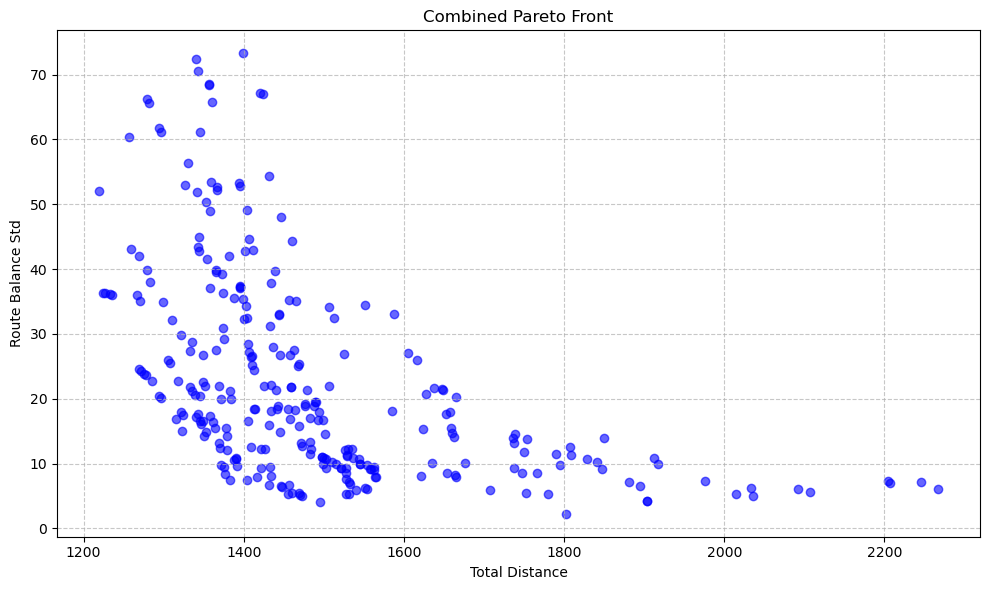

In [115]:
import random
import numpy as np
import matplotlib.pyplot as plt


def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=100, n_generations=80,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run NSGA-II
        nsga2 = NSGA2(pop_size=pop_size, n_generations=n_generations,
                      objective_functions=[total_distance, route_balance_std],
                      crossover_rate=crossover_rate,
                      mutation_rate=mutation_rate,
                      instance=instance,
                      n_vehicles=n_vehicles)

        final_population = nsga2.run()

        # Collect rank-1 solutions
        pareto_front = [p for p in final_population if p.rank == 1]
        all_solutions.extend(pareto_front)

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined rank-1 solutions
combined_pareto = run_multiple_experiments(instance=instance_a, n_vehicles=n_vehicles_a, runs=20)
print(f"Total combined rank-1 solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")




# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

